## VAE and InfoVAE on a bimodal gaussian distribution
A closer look at real-world data from eruptions at the Old Faithful in Yellowstone.

Eruption durations and wait time between eruptions at the Old Faithful approximately follow a bimodal gaussian distribution.

In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import torch
import torch.nn as nn
import torch.utils.data as tdata
from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

import vaes_ptorch.args as args
import vaes_ptorch.models as models
import vaes_ptorch.proba as proba
import vaes_ptorch.train_vae as train_vae
import vaes_ptorch.vae as vae_nn

In [3]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

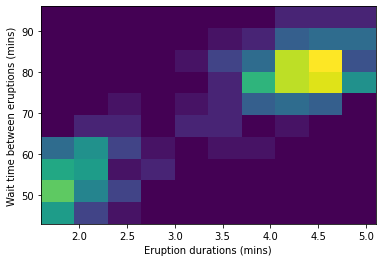

In [4]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

(272, 2)

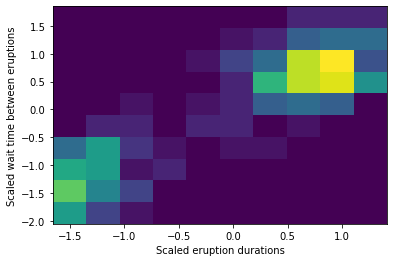

In [5]:
def scale_data(data):  # of shape n, p
    mean_, std_ = data.mean(0), data.std(0)
    return (data - mean_) / std_, (mean_, std_)


data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
data, _ = scale_data(data)
plt.hist2d(data[:, 0], data[:, 1], alpha=1.0)
plt.xlabel("Scaled eruption durations")
plt.ylabel("Scaled wait time between eruptions")
data.shape

In [6]:
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([-1.27396762, -1.20991826]), array([0.7038525 , 0.66846596])], sigma=[array([[0.05329039, 0.02814822],
       [0.02814822, 0.18299437]]), array([[0.13095257, 0.06084201],
       [0.06084201, 0.19575032]])], gamma=array([0.35587286, 0.64412714]))

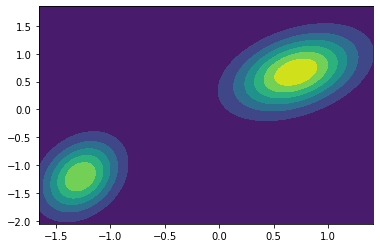

In [7]:
x = np.linspace(data[:, 0].min(), data[:, 0].max(), num=100)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), num=100)
X, Y = np.meshgrid(x, y)

XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)

pdfs = (
    sts.multivariate_normal.pdf(XY, theta.mu[0], theta.sigma[0])
    * theta.gamma[0]
    + sts.multivariate_normal.pdf(XY, theta.mu[1], theta.sigma[1])
    * theta.gamma[1]
)

plt.contourf(X, Y, pdfs)

In [69]:
data_dim = 2
latent_dim = 1

h_size = 64
h_layers = 6

lr = 5 * 1e-4
batch_size = 64
num_epochs = 500

print_every = 100

info_vae = True
end_scale = 100.0

# info_vae = False
# end_scale = 1.0

In [70]:
dataset = tdata.TensorDataset(torch.from_numpy(data).float())

In [71]:
def simple_collate(data):
    return torch.cat([x[0].unsqueeze(0) for x in data])

In [72]:
dataloader = tdata.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=simple_collate
)

In [73]:
encoder = models.get_mlp(
        in_dim=data_dim,
        out_dim=2 * latent_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    )
decoder = models.get_mlp(
        in_dim=latent_dim,
        out_dim=2 * data_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    )
vae = vae_nn.GaussianVAE(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    obs_model=proba.ObsModel.Gaussian,
)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = args.TrainArgs(
    num_epochs=num_epochs,
    info_vae=info_vae,
    print_every=print_every,
    target_div_scale=end_scale,
)

In [74]:
train_vae.train(
    train_data=dataloader, vae=vae, optimizer=optimizer, train_args=train_args
)

Training logs for step: 100, epoch: 20, info: loss: 6.34110 | nll: 2.73958 | div: 0.03602 | div_scale: 100.00000
Training logs for step: 200, epoch: 40, info: loss: 5.73863 | nll: 2.60704 | div: 0.03132 | div_scale: 100.00000
Training logs for step: 300, epoch: 60, info: loss: 5.36736 | nll: 1.77966 | div: 0.03588 | div_scale: 100.00000
Training logs for step: 400, epoch: 80, info: loss: 4.11231 | nll: 1.51192 | div: 0.02600 | div_scale: 100.00000
Training logs for step: 500, epoch: 100, info: loss: 5.34645 | nll: 1.48227 | div: 0.03864 | div_scale: 100.00000
Training logs for step: 600, epoch: 120, info: loss: 4.82724 | nll: 1.22152 | div: 0.03606 | div_scale: 100.00000
Training logs for step: 700, epoch: 140, info: loss: 4.97054 | nll: 1.08358 | div: 0.03887 | div_scale: 100.00000
Training logs for step: 800, epoch: 160, info: loss: 3.68359 | nll: 1.05253 | div: 0.02631 | div_scale: 100.00000
Training logs for step: 900, epoch: 180, info: loss: 4.02952 | nll: 0.74119 | div: 0.03288 |

({'loss': 1.0764493709212541,
  'nll': -1.9142724532665956,
  'div': 0.02990721803327162,
  'div_scale': 100.0},
 {})

In [75]:
def plot_pdf_2d(xs, ys, zs, to_dist):
    p_x_given_z = to_dist(zs)
    X, Y = np.meshgrid(xs, ys)
    XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)
    pdf = torch.exp(p_x_given_z.log_prob(torch.from_numpy(XY)).sum(-1)).mean(0).detach().numpy()
    plt.contourf(X, Y, pdf)


n_monte_carlo_samples = 500

### Inference

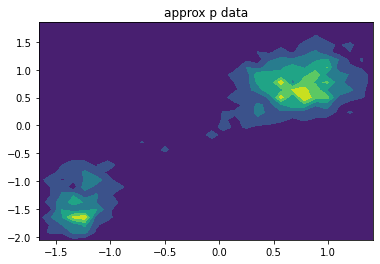

In [76]:
n = 30
x_grid = np.linspace(data[:, 0].min(), data[:, 0].max(), num=n)
y_grid = np.linspace(data[:, 1].min(), data[:, 1].max(), num=n)
z_samples = torch.randn((n_monte_carlo_samples, n, n, latent_dim))

vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf_2d(x_grid, y_grid, z_samples, vae.decode)
    plt.title("approx p data")
    plt.show()
    plt.close()

### Reconstruction

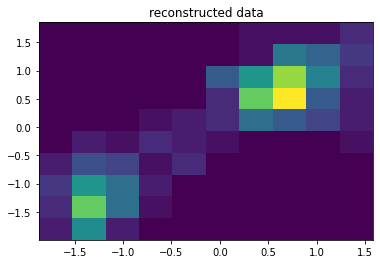

In [77]:
vae.eval()
with torch.no_grad():
    plt.figure()
    _, p_x_given_z = vae(torch.from_numpy(data).float())
    reconstructed = p_x_given_z.sample().detach().numpy()
    plt.hist2d(reconstructed[:, 0], reconstructed[:, 1], alpha=1.0)
    plt.title("reconstructed data")
    plt.show()
    plt.close()